In [1]:
!pip install jieba gensim

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#!/usr/bin/python
# -*- coding:utf-8 -*-

import jieba,os,re
from gensim import corpora, models, similarities

"""创建停用词列表"""
def stopwordslist():
    stopwords = [line.strip() for line in open('./stopwords.txt',encoding='UTF-8').readlines()]
    return stopwords

"""对句子进行中文分词"""
def seg_depart(sentence):
    sentence_depart = jieba.cut(sentence.strip())
    stopwords = stopwordslist()
    outstr = ''
    for word in sentence_depart:
        if word not in stopwords:
            outstr += word
            outstr += " "
    # outstr：'黄蜂 湖人 首发 科比 带伤 战 保罗 加索尔 ...'       
    return outstr


# 给出文档路径
filename = "./cnews.train.txt"
outfilename = "./cnews.train_jieba.txt"
inputs = open(filename, 'r', encoding='UTF-8')
outputs = open(outfilename, 'w', encoding='UTF-8')

# 把非汉字的字符全部去掉
# 将输出结果写入ouputs.txt中
for line in inputs:
    line = line.split('\t')[1]
    line = re.sub(r'[^\u4e00-\u9fa5]+','',line)
    line_seg = seg_depart(line.strip())
    outputs.write(line_seg.strip() + '\n')

outputs.close()
inputs.close()
print("删除停用词和分词成功！！！")

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.884 seconds.
Prefix dict has been built successfully.


删除停用词和分词成功！！！


In [3]:
fr = open('./cnews.train_jieba.txt', 'r',encoding='utf-8')
train = []
"""准备好训练语料，整理成gensim需要的输入格式"""
for line in fr.readlines():
    line = [word.strip() for word in line.split(' ')]
    train.append(line)
    # train: [['黄蜂', '湖人', '首发', '科比', '带伤', '战',...],[...],...]
    
"""构建词频矩阵，训练LDA模型"""
dictionary = corpora.Dictionary(train)
# corpus[0]: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1),...]
# corpus是把每条新闻ID化后的结果，每个元素是新闻中的每个词语，在字典中的ID和频率
corpus = [dictionary.doc2bow(text) for text in train]

lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)
topic_list = lda.print_topics(10)
print("10个主题的单词分布为：\n")
for topic in topic_list:
    print(topic)

10个主题的单词分布为：

(0, '0.067*"基金" + 0.012*"公司" + 0.010*"中" + 0.007*"市场" + 0.006*"分红" + 0.005*"经理" + 0.004*"新" + 0.004*"投资" + 0.004*"高" + 0.004*"产品"')
(1, '0.010*"分红" + 0.008*"活动" + 0.004*"中" + 0.003*"玩家" + 0.003*"基金" + 0.003*"市场" + 0.003*"公司" + 0.002*"中国" + 0.002*"企业" + 0.002*"台湾"')
(2, '0.020*"考试" + 0.007*"四级" + 0.006*"中" + 0.005*"英语" + 0.004*"大学" + 0.003*"搭配" + 0.003*"说" + 0.003*"新" + 0.003*"写作" + 0.003*"答案"')
(3, '0.005*"中" + 0.004*"说" + 0.004*"中国" + 0.004*"游戏" + 0.003*"拍摄" + 0.003*"装备" + 0.003*"采用" + 0.002*"元" + 0.002*"外观设计" + 0.002*"奖励"')
(4, '0.044*"基金" + 0.016*"投资" + 0.015*"市场" + 0.010*"公司" + 0.009*"股票" + 0.008*"中" + 0.007*"行业" + 0.006*"经济" + 0.006*"一季度" + 0.006*"业绩"')
(5, '0.018*"玩家" + 0.010*"游戏" + 0.005*"活动" + 0.005*"中" + 0.004*"中国" + 0.004*"视频" + 0.004*"兴业" + 0.004*"功能" + 0.004*"手机" + 0.004*"支持"')
(6, '0.005*"中" + 0.005*"单词" + 0.003*"时间" + 0.003*"说" + 0.003*"比赛" + 0.002*"应急" + 0.002*"热火" + 0.002*"中国" + 0.002*"詹姆斯" + 0.002*"新浪"')
(7, '0.011*"拍摄" + 0.009*"相机" + 0.008*"镜头" + 0.007*"

**使用 `u_mass` 一致性测算方法找到最佳主题数量。通过绘制结果，建议文本中的主题数量。**

新闻被视为主题的分布，主题又由词汇表中所有单词的分布表示。但是，我们不知道语料库中到底存在多少个主题数，以及哪个新闻属于哪个主题。潜在狄利克雷分配（LDA）是将词袋计数到较低维度的主题空间的概率转换。通过使用LDA，我们希望将新闻对主题的分配视为一个随机变量，这个变量根据已有数据估算得出。

In [9]:
coherence = []
for nb_topics in range(1,20):
    lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=nb_topics)
    cohm = models.CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    coherence.append(coh)
    print(nb_topics,coh)

1 -2.7787303306799362
2 -1.6403008343671908
3 -2.447302294852364
4 -2.051036151121683
5 -2.3992169368669165
6 -3.064282708670173
7 -2.8381999167829455
8 -2.5579583344970667
9 -2.8030547361453113
10 -2.950919629806514
11 -3.775786519623756
12 -3.0954403782564026
13 -3.4706343298094833
14 -3.326726967925119
15 -2.8626475450248625
16 -3.7173568513900817
17 -3.231560555320098
18 -4.051065860242299
19 -4.565026526539796


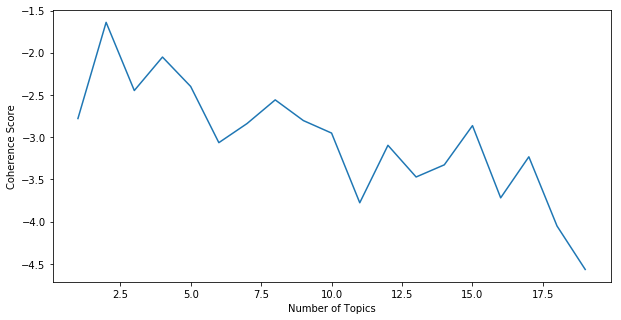

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(1,20),coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

下面我们可视化了一系列训练模型得出的每个主题的平均一致性得分，以及对应得不同数量的主题。平均分数相对较高的主题数量,就是我们寻找的最优值。因此，我们可以从下图中看到主题数量的最佳应该是4个左右。通常有非常短文档的语料库（比如本案例中是推文）往往比具有较长文档的语料库更难应用一致性模型。

**通过使用上述分析找到的主题数最佳值4个，对文本运行LDA。打印出4个主题中前10个高频词。接下来，看看看看结果是否具备合理性。**

In [20]:
k = 4

lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k)

In [21]:
from matplotlib import gridspec
import math

def plot_top_words(lda=lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(6,1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        print(top_words[i][:nb_words])
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

['基金', '公司', '投资', '市场', '中', '股票', '分红', '行业', '亿元', '收益']
['功能', '中', '基金', '机身', '游戏', '玩家', '支持', '说', '设计', '市场']
['考试', '中', '信息', '元', '时间', '做', '说', '基金', '活动', '市场']
['拍摄', '像素', '万', '采用', '英寸', '镜头', '功能', '中', '产品', '索尼']


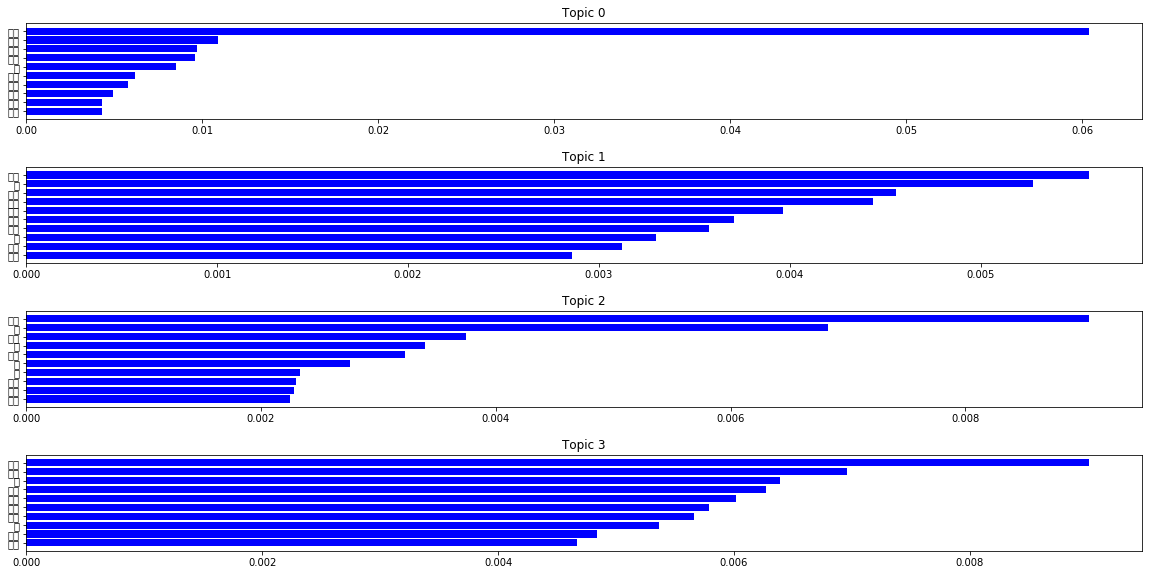

In [22]:
plot_top_words()